In [1]:
!pip install matplotlib
!pip install mplfinance

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
 
import tensorflow as tf
from tensorflow import keras
 
import copy
import time
from datetime import datetime 

plotly.offline.init_notebook_mode(connected=True)
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 讀取資料集
data = pd.read_csv('./Datasets/US_stocks_datasets/google.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.index.min(), data.index.max())
data.head()

2010-07-21 00:00:00 2017-11-10 00:00:00


Open    High     Low   Close  Volume  OpenInt
Date                                                       
2010-07-21  24.333  24.333  23.946  23.946   43321        0
2010-07-22  24.644  24.644  24.362  24.487   18031        0
2010-07-23  24.759  24.759  24.314  24.507    8897        0
2010-07-26  24.624  24.624  24.449  24.595   19443        0
2010-07-27  24.477  24.517  24.431  24.517    8456        0

In [4]:
data.tail()

Open     High      Low    Close  Volume  OpenInt
Date                                                         
2017-11-06  57.61  57.7372  57.2285  57.6500   41601        0
2017-11-07  57.29  57.3460  57.1446  57.2850   50935        0
2017-11-08  57.31  57.5500  57.2200  57.4900   71770        0
2017-11-09  57.23  57.2300  56.7100  56.9265   53130        0
2017-11-10  56.96  56.9600  56.3909  56.4000   29233        0

In [5]:
data.shape

(1565, 6)

In [6]:
# 切 train/test 資料集
date_split = '2016-01-01'
train = data[:date_split]
test = data[date_split:]
len(train), len(test)

(1117, 448)

In [7]:
import plotly.express as px
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()

In [8]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['AAPL.Open'],
                high=df['AAPL.High'],
                low=df['AAPL.Low'],
                close=df['AAPL.Close'])])

fig.show()

In [6]:
def plot_train_test(train, test, date_split):
    
    data = [
        Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='train'),
        Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='test')
    ]
    layout = {
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)
    
plot_train_test(train, test, date_split)

In [8]:
class Env:
    def __init__(self, data, history_time=90):
        self.data = data # 股票的歷史資料
        self.history_time = history_time # 存放多少天的 state，預設爲 90 天
        self.reset()

    def reset(self):
        self.t = 0 # 時間點

        # History = [state_(-90days), state_(-89days), ...]
        # state 在此設計爲"今日收盤價與昨日收盤價的價差"
        self.history = [0 for _ in range(self.history_time)] # history reset 90 天的值都爲 0, history = [state_(-90days), state_(-89days), ...]

        self.profits = 0
        self.positions = [] # 收盤價(close)的資料
        self.position_value = 0 # 這是 profit
        self.done = False # 環境到達結束
        return [self.position_value] + self.history
  
    # env(環境)與 agent 的每一步互動，輸入參數為 agent 
    def step(self, act):
        reward = 0 # 每一步開始都先初始化 reward 為 0

        # action
        # 1 --> buy
        # 2 --> sell

        # 如果採取的策略為買入，則將收盤價放進 position 陣列內，就是你至今買入的成本
        if act == 1:
          # print("action: {}".format(act))
          self.positions.append(self.data.iloc[self.t, :]['Close']) # 不同時間點的買入成本

        # 如果採取的策略為賣出，則計算獲利多少
        # reward 也是在賣出時才判定決策對不對
        # **說明** 賣出才是重點，決定你有沒有賺
        elif act == 2:
          # 如果沒有買入什麼，但卻判定要賣出，則給 reward = -1 的懲罰
          if len(self.positions) == 0:
            reward = -1

          # 先前有買入，開始計算這次清倉的獲利值
          else:
            profits = 0 # 初始獲利值
            for p in self.positions:
                profits += (self.data.iloc[self.t, :]['Close'] - p) # 正的為賺，負的為賠

            reward += profits
            self.profits += profits
            self.positions = [] # 賣出後清空
  
        # 下一個 step
        self.t += 1 # 每個 step 後再加往後一日
        self.position_value = 0 # profit
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0) # 把 history 的第一個（最一開始)的 state 給 popout, [0, 1, 2] --> [1 , 2]
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[self.t-1, :]['Close']) # 存入 state，爲今昨的收盤價價差

        # reward clipping
        # 這裡可以再優化 r > 0 的部份，好比獲利多少要給多少 reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
    
        return [self.position_value] + self.history, reward, self.done

In [9]:
env = Env(train)
env.reset()
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

([0.5410000000000004, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5410000000000004], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5410000000000004, 0.019999999999999574], 1, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5410000000000004, 0.019999999999999574, 0.08800000000000097], 0, False)


In [17]:
# Deep Q-Learning Network
# 模型在此採用 subclassing 寫法，也可以用 Sequential 或 Function API 寫法
class DQN(keras.models.Model):
    def __init__(self, hidden_sz, output_sz):
        super(DQN, self).__init__()
        self.fc1 = keras.layers.Dense(hidden_sz, activation='relu')
        self.fc2 = keras.layers.Dense(hidden_sz, activation='relu')
        self.fc3 = keras.layers.Dense(output_sz)
    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        outputs = self.fc3(x)
        return outputs

In [18]:
# Hyperparameters
epochs = 50
batch_sz = 20

# RL Hyperparameters
epsilon = 1.0 # epsilon-greedy
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 200
terminal_step = len(env.data) - 1 # 資料最後一筆
step_count = 0
discount_factor = 0.98
train_freq = 10
update_freq = 20
memory = [] # ()
memory_sz = 200 # memory 最長爲 200
total_rewards = [] # 圖形化結果用
total_losses = [] # 圖形化結果用
show_log_freq = 5

# Loss & Optimizer
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(lr=1e-3)

# Init model
eval_network = DQN(hidden_sz=100, output_sz=3) # evaluation network
target_network = copy.deepcopy(eval_network) # target network

In [19]:
# Training
start = datetime.now()
for epoch in range(epochs):

    # init
    prev_history = env.reset()
    step = 0
    done = False

    total_reward = 0 # 每一個 epoch 結束的總 reward
    total_loss = 0 # 每一個 epoch 結束的總 loss

    while not done and step < terminal_step: # 一直執行到最後一步

        # 選擇 action
        select_action()
        if np.random.rand() > epsilon:
            q_value = eval_network(np.array(prev_history, dtype=np.float32).reshape(1, -1))
            action = np.argmax(q_value)
        else:
            action = np.random.randint(3) # 隨機選動作

        # do action
        history, reward, done = env.step(action)

        # add memory
        memory.append((prev_history, action, reward, history, done))
        if len(memory) > memory_sz: # 保持 memory size 長度
            memory.pop(0)

        # Training 和 Update Q 值
        if len(memory) == memory_sz: # 當 memory 累積到 200 個才開始訓練
            # training
            if step_count % train_freq == 0: # 當步數爲 train_freq 的倍數時，才去訓練 Q
                shuffled_memory = np.random.permutation(memory) # 將訓練集(memory)打散
                memory_idx = range(len(shuffled_memory))

                for i in memory_idx[::batch_sz]: # (start=0, end=200, step=20)
                    batch = np.array(shuffled_memory[i: i+batch_sz]) # 最後一個 batch 將不會是剛好的 batch_sz
                    batch_prev_history = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_sz, -1) # 取出一個 batch 裡的 previous history
                    batch_prev_action = np.array(batch[:, 1].tolist(), dtype=np.int32) # 取出一個 batch 裡的 action
                    batch_reward = np.array(batch[:, 2].tolist(), dtype=np.int32) # 取出一個 batch 裡的 reward
                    batch_history = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_sz, -1) # 取出一個 batch 裡的 history
                    batch_done = np.array(batch[:, 4].tolist(), dtype=np.bool) # 取出一個 batch 裡的 done (是否回合結束了)

                    with tf.GradientTape() as tape:
                        eval_q = eval_network(batch_prev_history, training=True) # 將 history 丟給 model 去算 q_pred
                        max_eval_q = np.max(eval_q.numpy(), axis=1) # 求出最大的 q 值作爲 q_pred
                        target_q_value = copy.deepcopy(eval_q.numpy())
                        for j in range(batch_sz):
                            # Q_target = reward + discount_factor*max_q
                            target_q_value[j, batch_prev_action[j]] = batch_reward[j] + discount_factor*max_eval_q[j]*(not batch_done[j])
                        loss = loss_fn(eval_q, target_q_value)
                        total_loss += loss.numpy()
                    grads = tape.gradient(loss, eval_network.trainable_weights)
                    optimizer.apply_gradients(zip(grads, eval_network.trainable_weights))

            # updating
            if step_count % update_freq == 0:
                target_network = copy.deepcopy(eval_network)

        # 減少隨機性
        if epsilon > epsilon_min and step_count > start_reduce_epsilon:
            epsilon -= epsilon_decrease

        # next step
        step += 1
        step_count += 1
        total_reward += reward
        prev_history = history

    # 圖示化模型訓練情況
    total_rewards.append(total_reward)
    total_losses.append(total_loss)

    # Log
    if (epoch+1) % show_log_freq == 0:
        log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
        log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
        elapsed_time = datetime.now()-start
        print("Epoch: {}, Epsilon: {}, Total steps: {}, Reward: {}, Loss: {}, Elapsed time: {}".format(epoch+1, epsilon, step_count, log_reward, log_loss, elapsed_time))
        start = datetime.now()

Epoch: 5, Epsilon: 0.0999999999999992, Total steps: 5580, Reward: -14.4, Loss: 56.90588396816747, Elapsed time: 0:00:37.512814
Epoch: 10, Epsilon: 0.0999999999999992, Total steps: 11160, Reward: 30.4, Loss: 40.48340503736981, Elapsed time: 0:00:38.734293
Epoch: 15, Epsilon: 0.0999999999999992, Total steps: 16740, Reward: 83.2, Loss: 39.24616637068684, Elapsed time: 0:00:39.050612
Epoch: 20, Epsilon: 0.0999999999999992, Total steps: 22320, Reward: 87.6, Loss: 30.030691154653322, Elapsed time: 0:00:38.826333
Epoch: 25, Epsilon: 0.0999999999999992, Total steps: 27900, Reward: 114.2, Loss: 32.01423629988712, Elapsed time: 0:00:39.271686
Epoch: 30, Epsilon: 0.0999999999999992, Total steps: 33480, Reward: 116.0, Loss: 21.05675627722085, Elapsed time: 0:00:39.048838
Epoch: 35, Epsilon: 0.0999999999999992, Total steps: 39060, Reward: 132.2, Loss: 11.904304630125988, Elapsed time: 0:00:38.784929
Epoch: 40, Epsilon: 0.0999999999999992, Total steps: 44640, Reward: 143.6, Loss: 10.259905131772758,

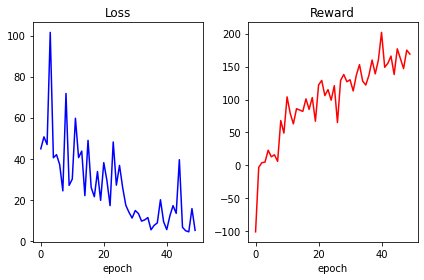

In [20]:
# 圖示化模型訓練情況
def plot_loss_reward(total_losses, total_rewards):
    plt.subplot(1,2,1)
    plt.plot(total_losses, 'blue')
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(total_rewards, 'red')
    plt.xlabel('epoch')
    plt.title('Reward')
    plt.tight_layout()
    plt.show()

plot_loss_reward(total_losses, total_rewards)

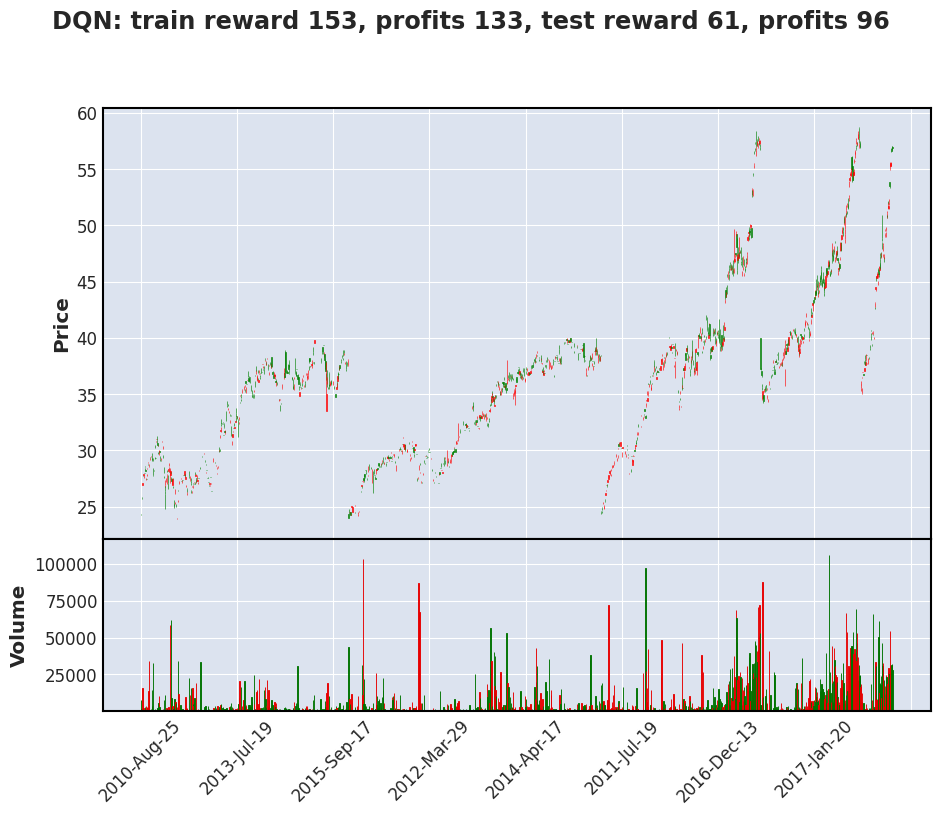

In [21]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    
    # train
    prev_history = train_env.reset()
    train_acts = []
    train_rewards = []
    
    for _ in range(len(train_env.data) -1):
        
        prev_action = Q(np.array(prev_history, dtype=np.float32).reshape(1, -1))
        prev_action = np.argmax(prev_action)
        train_acts.append(prev_action)
        
        history, reward, done = train_env.step(prev_action)
        train_rewards.append(reward)
        
        prev_history = history
        
    train_profits = train_env.profits
#     print(train_profits)
    
    # test
    prev_history = test_env.reset()
    test_acts = []
    test_rewards = []
    
    for _ in range(len(test_env.data) -1):
        
        prev_action = Q(np.array(prev_history, dtype=np.float32).reshape(1, -1))
        prev_action = np.argmax(prev_action)
        test_acts.append(prev_action)
        
        history, reward, done = test_env.step(prev_action)
        test_rewards.append(reward)
        
        prev_history = history
        
    test_profits = test_env.profits
#     print(test_profits)
    
    # plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    test2 = test_copy[test_copy['act'] == 2]
    
    mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
    s  = mpf.make_mpf_style(base_mpf_style='default', marketcolors=mc)
    title = '{}: train reward {}, profits {}, test reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    kwargs = dict(type='candle', volume=True, title=title, style=s, figscale=1.5, figratio=(12,9))
    data = pd.concat([train0, train1, train2, test0, test1, test2])
    mpf.plot(data, **kwargs)
#     print(train_copy)
#     print(test_copy)
    return train_copy, test_copy

train_, test_ = plot_train_test_by_q(Env(train), Env(test), target_network, 'DQN')

In [22]:
train_.iloc[90:100,:]

Open    High     Low   Close  Volume  OpenInt  act  reward
Date                                                                    
2010-11-30  27.514  27.514  27.436  27.436    1856        0  1.0     0.0
2010-12-01  27.698  27.903  27.698  27.903    1683        0  2.0     1.0
2010-12-02  27.903  28.348  27.903  28.308   26077        0  1.0     0.0
2010-12-03  28.268  28.358  28.268  28.318    4593        0  1.0     0.0
2010-12-06  28.135  28.378  28.135  28.378    2253        0  2.0     1.0
2010-12-07  28.540  28.540  28.473  28.473   10730        0  1.0     0.0
2010-12-08  28.443  28.443  28.212  28.298    2238        0  1.0     0.0
2010-12-09  28.298  28.298  28.298  28.298     370        0  1.0     0.0
2010-12-10  28.338  28.453  28.338  28.443    2114        0  0.0     0.0
2010-12-13  28.540  28.736  28.540  28.628    6087        0  2.0     1.0